In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, classification_report, f1_score
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("Final_Dataset_Genes.csv")
df.head(1)

,Unnamed: 0,LINC01972,GSTM2,DPEP2,VPS29,MIR3654,SORD,RRBP1,SLC25A43,MIR3615,...,ADORA2A,IL36RN,TPD52,NECTIN4.AS1,KLC1,ZNF784,BRF1,TAF1,MIR8078,Label
0,0,0.0,1.360425,0.331361,6.444548,0.0,4.137351,7.007994,5.804019,0.0,...,0.305312,0.345053,5.913141,0.563678,2.803097,5.238381,4.577846,5.437249,0.706995,1


In [3]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
# Separate label and feature columns
y = df['Label']
X = df.drop(columns=['Label'])

In [7]:
df_gene_outliers=pd.read_csv("Odd_Genes/Strictly_Exclusive_Gene_Status_All.csv")
l1=list(df_gene_outliers["Gene"])

In [21]:
# Removing Outlier Genes
Outliers=["TREX1",
"ADIRF",
"TNFRSF6B",
"NOTCH2NLB",
"GP1BB",
"SPDYE11",
"ZNF593",
"SPDYE8",
"DND1",
"SPDYE14",
"RSC1A1",
"CIDEB"]


In [6]:
df_1=pd.read_csv("Regulatory_Results/regula_required.csv")
df_1.drop("Unnamed: 0",axis=1,inplace=True)

In [11]:
df_1.drop("Label",axis=1,inplace=True)

In [11]:
X.drop(l1,axis=1,inplace=True)

In [32]:
X=X[list(df_1.columns)]

In [35]:
X.drop(Outliers,axis=1,inplace=True)

# PCA

In [13]:
#applying the pca
std_scaler=StandardScaler()
X_scaled=std_scaler.fit_transform(X)

# Keeping all components initially
pca = PCA()
pca_components = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_ #explained variance ratio
cumulative_variance = np.cumsum(explained_variance)  #cummulative explained variance

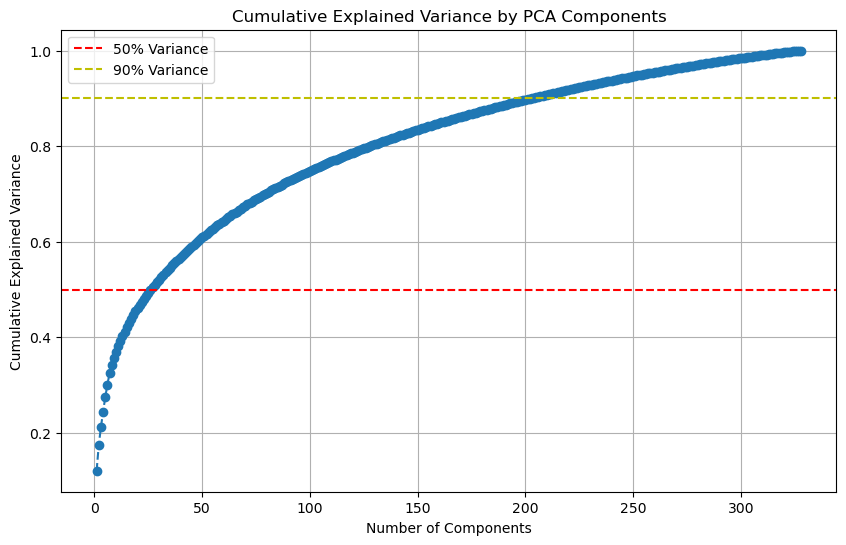

In [14]:
#scree plot for the explained variance ratio and cummulative explained varinace ratio 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.50, color='r', linestyle='--', label='50% Variance')
plt.axhline(y=0.90, color='y', linestyle='--', label='90% Variance')
plt.legend()
plt.show()

In [15]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance)+1)),
    y=cumulative_variance,
    mode='lines+markers',
    name='Cumulative Explained Variance'
))
fig.add_hline(y=0.9, line_dash="dash", line_color="red", annotation_text="90% Cutoff")
fig.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance)+1)),
    y=explained_variance,
    mode='lines+markers',
    name='Individual Explained Variance'
))
fig.update_layout(
    title="PCA Explained Variance (Interactive Scree Plot)",
    xaxis_title="Principal Component",
    yaxis_title="Explained Variance",
    template="plotly_white"
)
fig.show()

In [16]:
# for visualizing the 2d pca 

pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(X_scaled)

import plotly.express as px
df_2d = pd.DataFrame(reduced_2d, columns=['PC1', 'PC2'])
df_2d['label'] = y.values

fig = px.scatter(df_2d, x='PC1', y='PC2', color='label',
                 title='PCA 2D Projection',
                 labels={'label': 'Group'})
fig.show()

In [17]:
# 3d pca plot 
pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(X_scaled)

df_3d = pd.DataFrame(reduced_3d, columns=['PC1', 'PC2', 'PC3'])
df_3d['label'] = y.values

fig = px.scatter_3d(df_3d, x='PC1', y='PC2', z='PC3', color='label',
                    title='PCA 3D Projection')
fig.show()

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


def run_nested_cv_pca_pipeline(X, y, n_components_list=[25,50,100,200,250]):
    # Increase outer cross-validation folds to 10
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    results = []
    stable_genes_tracker = defaultdict(int)

    n_permutations = 20 # Number of permutations for permutation test

    for n_components in n_components_list:
        print(f"\n==== PCA Components = {n_components} ====")

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            print(f"\n-- Fold {fold + 1} --")
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Standardize
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # PCA on training data only
            pca = PCA(n_components=n_components, random_state=42)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            # Track top 100 genes from PCs
            loading_matrix = pd.DataFrame(np.abs(pca.components_), columns=X.columns)
            for i in range(n_components):
                # Extract top 100 genes instead of 20
                top_genes = loading_matrix.iloc[i].sort_values(ascending=False).head(100).index
                for gene in top_genes:
                    stable_genes_tracker[gene] += 1

            # Models to test
            models = {
                "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
                "SVM (RBF)": SVC(class_weight='balanced', kernel='rbf', probability=True),
                "Random Forest": RandomForestClassifier(class_weight='balanced'),
                "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=(sum(y_train==0)/sum(y_train==1)))
            }

            param_grids = {
                "Logistic Regression": {"C": [0.01, 0.1, 1, 10]},
                # Increase inner cross-validation folds to 5
                "SVM (RBF)": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']},
                "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 10]},
                "XGBoost": {"n_estimators": [100, 200], "max_depth": [3, 6]}
            }

            for model_name, model in models.items():
                # Increase inner cross-validation folds to 5
                grid = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=5)
                grid.fit(X_train_pca, y_train)
                best_model = grid.best_estimator_

                y_pred = best_model.predict(X_test_pca)
                f1 = f1_score(y_test, y_pred)
                roc = roc_auc_score(y_test, best_model.predict_proba(X_test_pca)[:,1]) if hasattr(best_model, 'predict_proba') else None

                cm = confusion_matrix(y_test, y_pred)
                print(f"{model_name} - F1: {f1:.4f}, ROC-AUC: {roc:.4f}" if roc else f"{model_name} - F1: {f1:.4f}")
                print("Confusion Matrix:\n", cm)

                # Permutation Test
                permutation_f1_scores = []
                for _ in range(n_permutations):
                    y_test_shuffled = np.random.permutation(y_test)
                    shuffled_f1 = f1_score(y_test_shuffled, y_pred)
                    permutation_f1_scores.append(shuffled_f1)

                avg_permutation_f1 = np.mean(permutation_f1_scores)
                print(f"[Permutation] {model_name} - F1 with shuffled labels: {avg_permutation_f1:.4f}")

                results.append({
                    "Model": model_name,
                    "PCA_Components": n_components,
                    "Fold": fold+1,
                    "F1_Score": f1,
                    "ROC_AUC": roc,
                    "Permutation_F1_Score": avg_permutation_f1, # Add permutation F1
                    "Best_Params": grid.best_params_
                })

    # Results summary
    df_results = pd.DataFrame(results)
    print("\n===== CV Summary =====")
    print(df_results.groupby(['Model', 'PCA_Components'])[['F1_Score', 'ROC_AUC', 'Permutation_F1_Score']].mean().round(4))

    # Stable genes
    # Print top 100 stable genes
    print("\nTop 100 Stable Genes Across Folds and PCs:")
    stable_genes_df = pd.DataFrame(sorted(stable_genes_tracker.items(), key=lambda x: x[1], reverse=True), columns=["Gene", "Count"])
    print(stable_genes_df.head(100)) # Ensure 100 genes are printed

     #Plotting F1 score vs PCA components
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_results, x='PCA_Components', y='F1_Score', hue='Model', marker='o')
    plt.title("F1 Score vs. PCA Components")
    plt.ylabel("F1 Score")
    plt.xlabel("Number of PCA Components")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Regulatory_Results/f1_vs_pca_components.png")
    plt.close()

    # Plotting ROC AUC vs PCA components
    # if df_results['ROC_AUC'].notna().all():
    #     plt.figure(figsize=(10, 6))
    #     sns.lineplot(data=df_results, x='PCA_Components', y='ROC_AUC', hue='Model', marker='s')
    #     plt.title("ROC AUC vs. PCA Components")
    #     plt.ylabel("ROC AUC")
    #     plt.xlabel("Number of PCA Components")
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.savefig("roc_auc_vs_pca_components.png")
    #     plt.close()

    return df_results, stable_genes_df

# Assuming X and y are already defined in your environment
a,b=run_nested_cv_pca_pipeline(X, y)


==== PCA Components = 25 ====

-- Fold 1 --
Logistic Regression - F1: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 2  0]
 [ 0 31]]
[Permutation] Logistic Regression - F1 with shuffled labels: 0.9403
SVM (RBF) - F1: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 2  0]
 [ 0 31]]
[Permutation] SVM (RBF) - F1 with shuffled labels: 0.9355
Random Forest - F1: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 2  0]
 [ 0 31]]
[Permutation] Random Forest - F1 with shuffled labels: 0.9387
XGBoost - F1: 0.9667, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 2  0]
 [ 2 29]]
[Permutation] XGBoost - F1 with shuffled labels: 0.9067

-- Fold 2 --
Logistic Regression - F1: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 2  0]
 [ 0 31]]
[Permutation] Logistic Regression - F1 with shuffled labels: 0.9355
SVM (RBF) - F1: 0.9841, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 1  1]
 [ 0 31]]
[Permutation] SVM (RBF) - F1 with shuffled labels: 0.9540
Random Forest - F1: 0.9841, ROC-AUC: 1.0000
Confusion Matrix:
 [[ 1  1]
 [ 0 31]]

In [21]:
print(list(b["Gene"].iloc[:400]))

['MIR9500', 'MIR4471', 'OR10G8', 'LINC02464', 'MIR4310', 'MIR4787', 'SNORD115.4', 'PRR20C', 'GAGE12G', 'MIR3202.2', 'MIR6879', 'MIR514A3', 'CDH23.AS1', 'TTTY11', 'OR10R2', 'KRTAP26.1', 'POTEB3', 'ADIPOQ', 'HDGFL1', 'OR52R1', 'LINC00507', 'LINC02443', 'FAM197Y6', 'KRTAP22.1', 'MIR3675', 'PRR30', 'LINCADL', 'GPR101', 'MIR153.2', 'IGHVII.67.1', 'LINC01906', 'MIR3158.1', 'MIR3158.2', 'SNORD115.2', 'BPIFB6', 'VENTXP1', 'OR6C68', 'MIR6134', 'LINC02329', 'IGKV2D.38', 'LINC00280', 'PRR20D', 'RNA5S15', 'LINC02309', 'TRBV21OR9.2', 'RNA5S6', 'OR8B3', 'MIR103B1', 'RNA5S12', 'RNA5S10', 'USH2A.AS2', 'AMELY', 'LINC01745', 'LINC02342', 'RNA5S14', 'PPY', 'MIR4528', 'ASZ1', 'MIR1255B1', 'OC90', 'OR4F6', 'LINC01443', 'TBC1D28', 'LINC02644', 'RNA5S1', 'RNA5S13', 'RNA5S4', 'RNA5S2', 'RNA5S8', 'RNA5S16', 'RNA5S11', 'MIR4662B', 'LCN9', 'LINC02045', 'LINC01760', 'NOX3', 'RNA5S17', 'LINC01822', 'LINC00297', 'DEFB128', 'MIR4495', 'TRIM49D1', 'RNA5S5', 'RNA5S7', 'RNA5S3', 'OR14A16', 'LINC02488', 'OR6C76', 'OR10J

In [22]:
b["Gene"].iloc[:727].to_csv("PCA_Gene.csv")


>>> Processing Random Forest
Random Forest RFE + GridSearchCV: Mean F1 = 0.9653 (+/- 0.0693)

>>> Processing Logistic Regression
Logistic Regression RFE + GridSearchCV: Mean F1 = 1.0000 (+/- 0.0000)

>>> Processing SVM (Linear)
SVM (Linear) RFE + GridSearchCV: Mean F1 = 0.9653 (+/- 0.0693)

>>> Processing XGBoost
XGBoost RFE + GridSearchCV: Mean F1 = 0.9653 (+/- 0.0693)


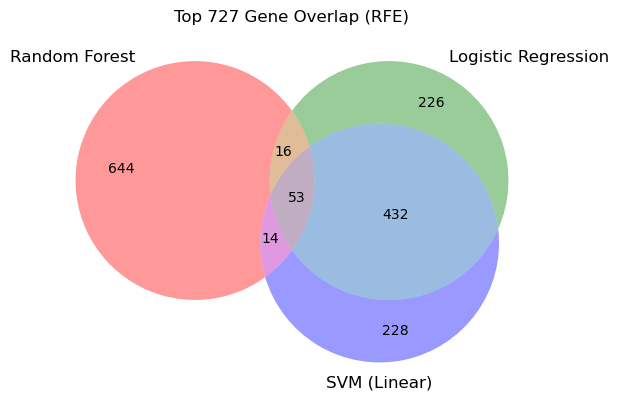


>>> Best Model: Logistic Regression with F1 = 1.0000


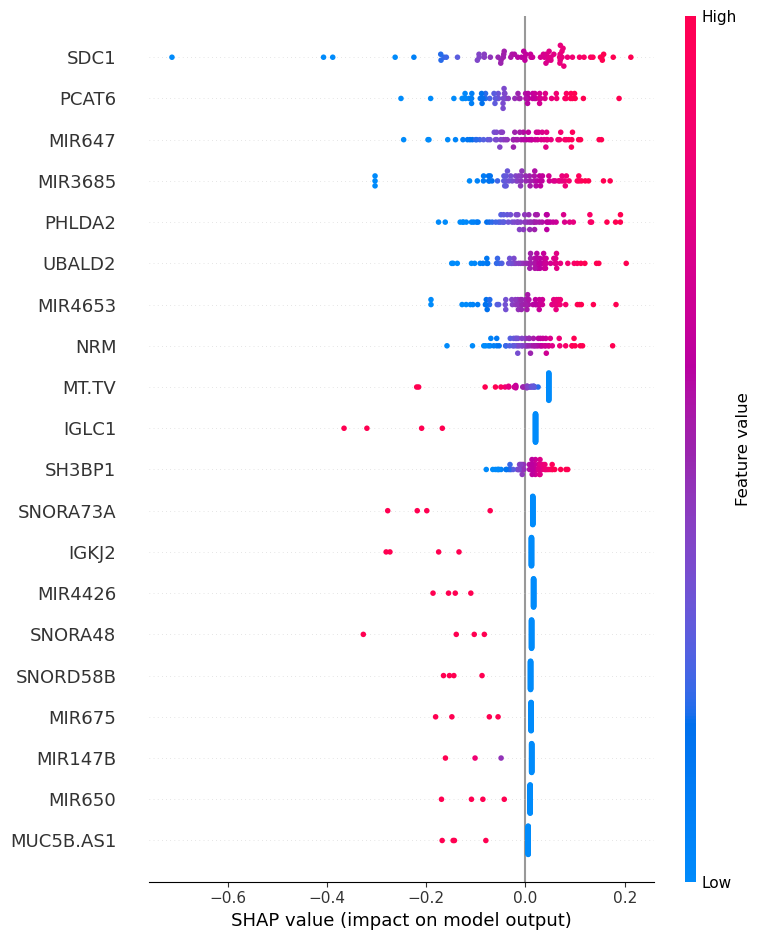


--- Accuracy Scores ---
Train Accuracy: 1.0
Validation Accuracy: 1.0
Test Accuracy: 1.0
Validation F1: 1.0
Test F1: 1.0


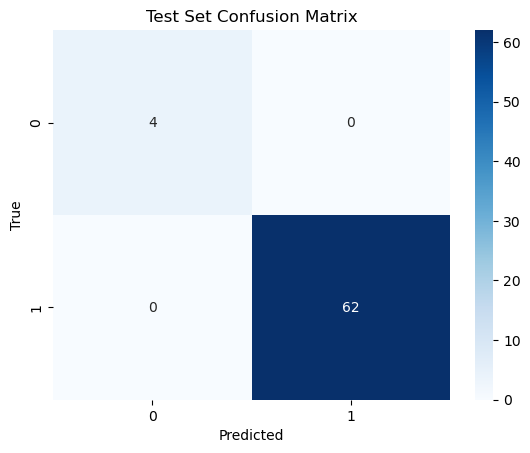

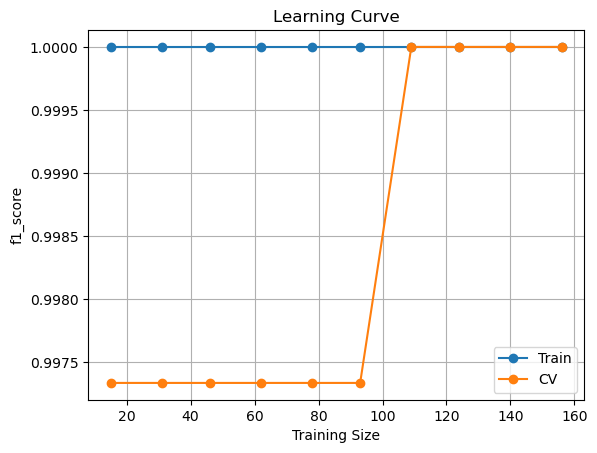

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score
)
from matplotlib_venn import venn3
import shap
import warnings 
warnings.filterwarnings("ignore")

# 1. 60-20-20 split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# 2. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. RFE with Multiple Base Models and Hyperparameter Tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_configs = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "class_weight": ['balanced']
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, solver='liblinear'),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ['l1', 'l2'],
            "class_weight": ['balanced']
        }
    },
    "SVM (Linear)": {
        "model": SVC(kernel='linear', probability=True),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "class_weight": ['balanced']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=(sum(y_train==0)/sum(y_train==1)),error_score='raise'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7]
        }
    }
}

rfe_scores = {}
selected_features_per_model = {}
best_models = {}

for name, config in model_configs.items():
    print(f"\n>>> Processing {name}")
    base_model = config["model"]
    param_grid = config["params"]

    rfe = RFE(estimator=base_model, n_features_to_select=727, step=0.1)
    rfe.fit(X_train_scaled, y_train)
    selected_features = X.columns[rfe.support_].tolist()
    selected_features_per_model[name] = selected_features

    X_train_rfe = rfe.transform(X_train_scaled)
    grid = GridSearchCV(base_model, param_grid, cv=kfold, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_rfe, y_train)
    best_models[name] = grid.best_estimator_
    scores = cross_val_score(grid.best_estimator_, X_train_rfe, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
    rfe_scores[name] = scores
    print(f"{name} RFE + GridSearchCV: Mean F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Venn diagram for 3 model overlaps (choose 3 for simplicity)
sets = list(selected_features_per_model.values())
if len(sets) >= 3:
    set1, set2, set3 = map(set, sets[:3])
    venn3([set1, set2, set3], set_labels=list(selected_features_per_model.keys())[:3])
    plt.title("Top 727 Gene Overlap (RFE)")
    plt.show()

# 4. Automatically select the best model
best_model_name = max(rfe_scores, key=lambda k: rfe_scores[k].mean())
best_model = best_models[best_model_name]
print(f"\n>>> Best Model: {best_model_name} with F1 = {rfe_scores[best_model_name].mean():.4f}")

# Use its features for downstream pipeline
final_selected_features = selected_features_per_model[best_model_name]
X_train_sel = X_train[final_selected_features].values
X_val_sel = X_val[final_selected_features].values
X_test_sel = X_test[final_selected_features].values

# 5. Train best model
best_model.fit(X_train_sel, y_train)

# SHAP explanation
explainer = shap.Explainer(best_model, X_train_sel)
shap_values = explainer(X_test_sel)
shap.summary_plot(shap_values, features=X_test_sel, feature_names=final_selected_features)

# 6. Evaluate
y_train_pred = best_model.predict(X_train_sel)
y_val_pred = best_model.predict(X_val_sel)
y_test_pred = best_model.predict(X_test_sel)

y_val_prob = best_model.predict_proba(X_val_sel)[:, 1]
y_test_prob = best_model.predict_proba(X_test_sel)[:, 1]

print("\n--- Accuracy Scores ---")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Validation F1:", f1_score(y_val, y_val_pred, average='macro'))
print("Test F1:", f1_score(y_test, y_test_pred, average='macro'))

# Confusion matrix on test
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC curve on test
# fpr, tpr, _ = roc_curve(y_test, y_test_prob)
# roc_auc = roc_auc_score(y_test, y_test_prob)
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.title("Test ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
# plt.legend(); plt.grid(True); plt.show()

# PR curve on test
# precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
# pr_auc = auc(recall, precision)
# plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
# plt.title("Test Precision-Recall Curve")
# plt.xlabel("Recall"); plt.ylabel("Precision")
# plt.legend(); plt.grid(True); plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_sel, y_train, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="CV")
plt.title("Learning Curve")
plt.xlabel("Training Size"); plt.ylabel("f1_score")
plt.legend(); plt.grid(True); plt.show()

# Save selected genes for each model
pd.DataFrame.from_dict(selected_features_per_model, orient='index').transpose().to_csv("All_Results/selected_genes_per_model_All.csv", index=False)



>>> Processing Random Forest


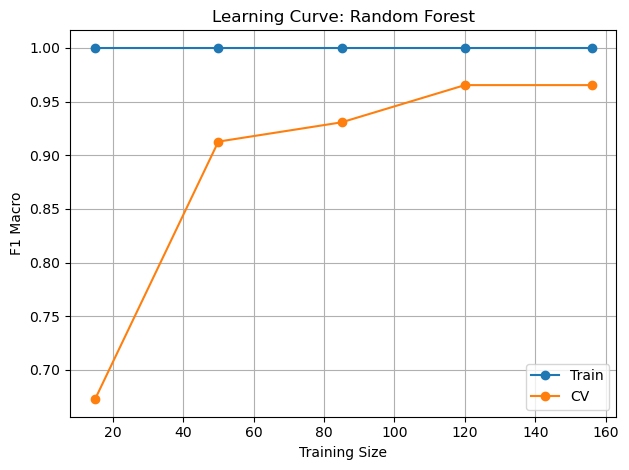


>>> Processing Logistic Regression


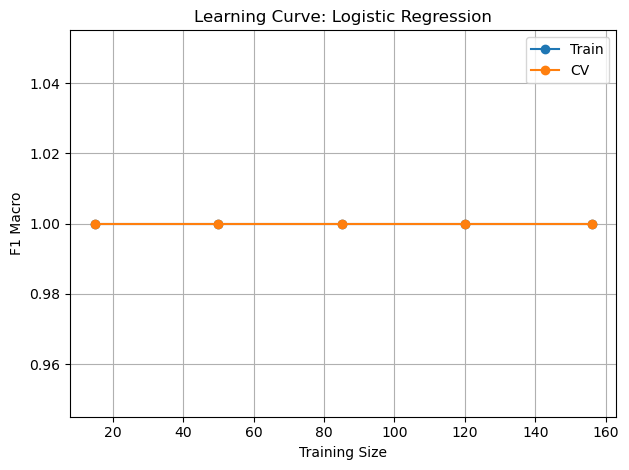


>>> Processing SVM (Linear)


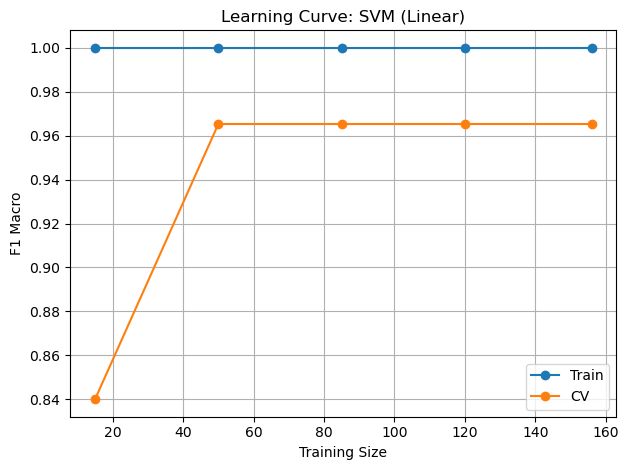


>>> Processing XGBoost


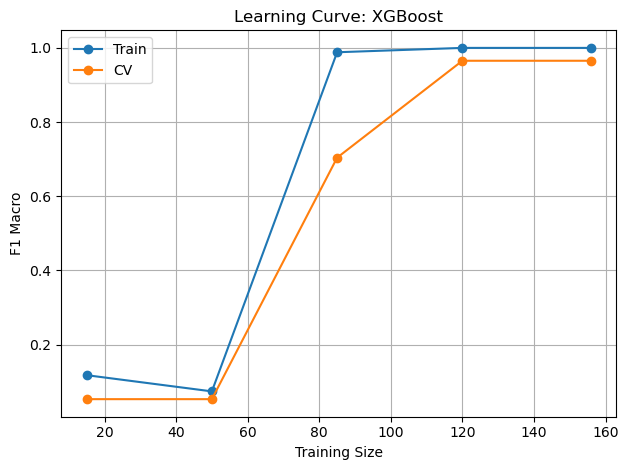

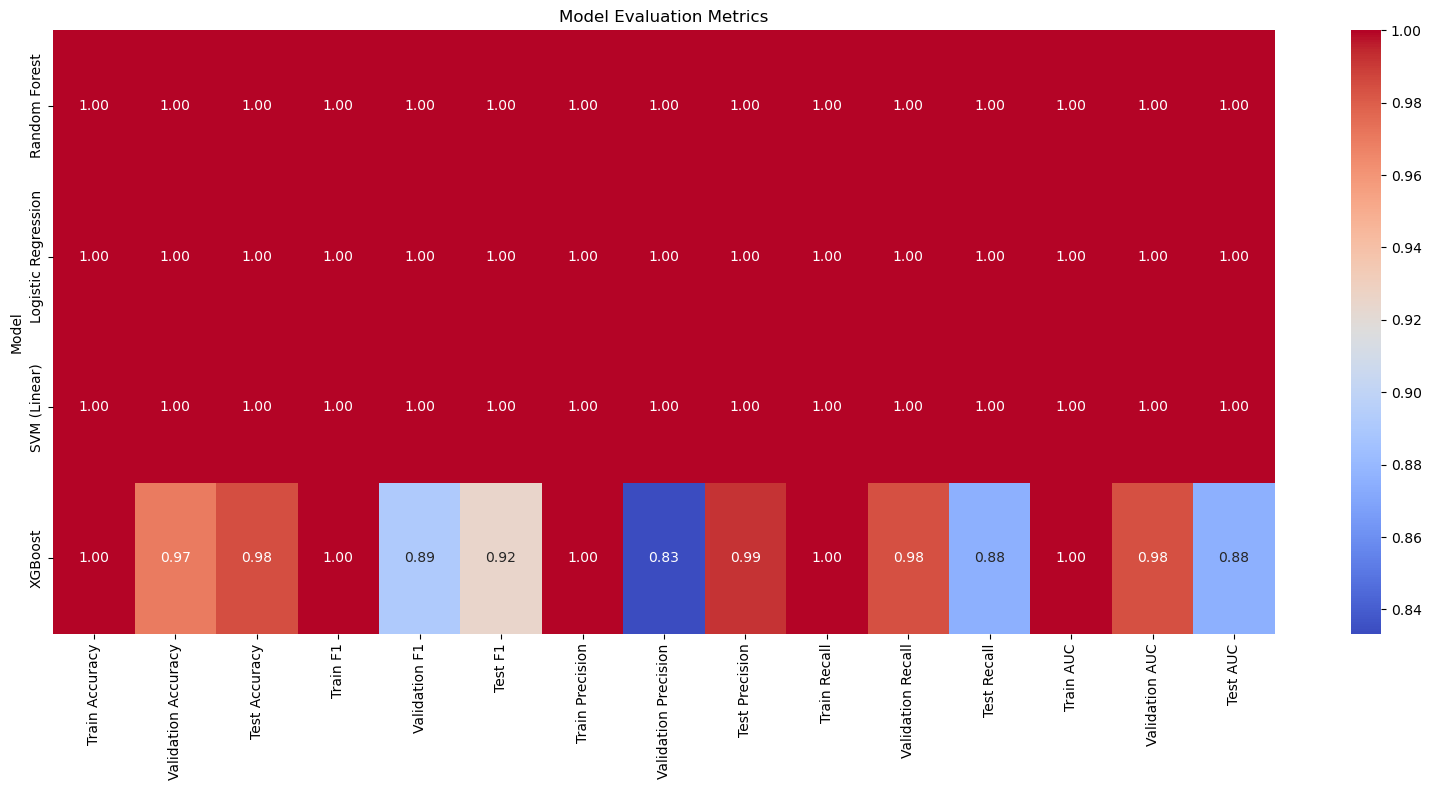

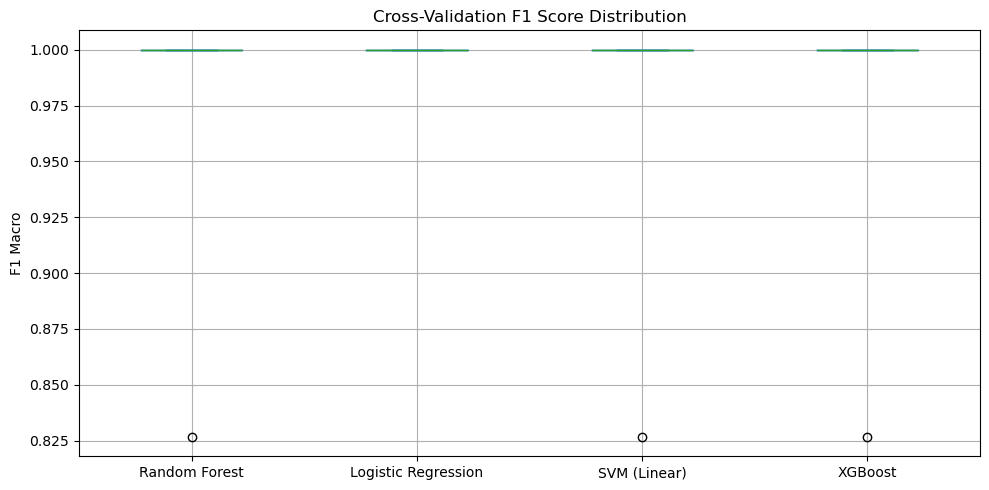

<Figure size 640x480 with 0 Axes>

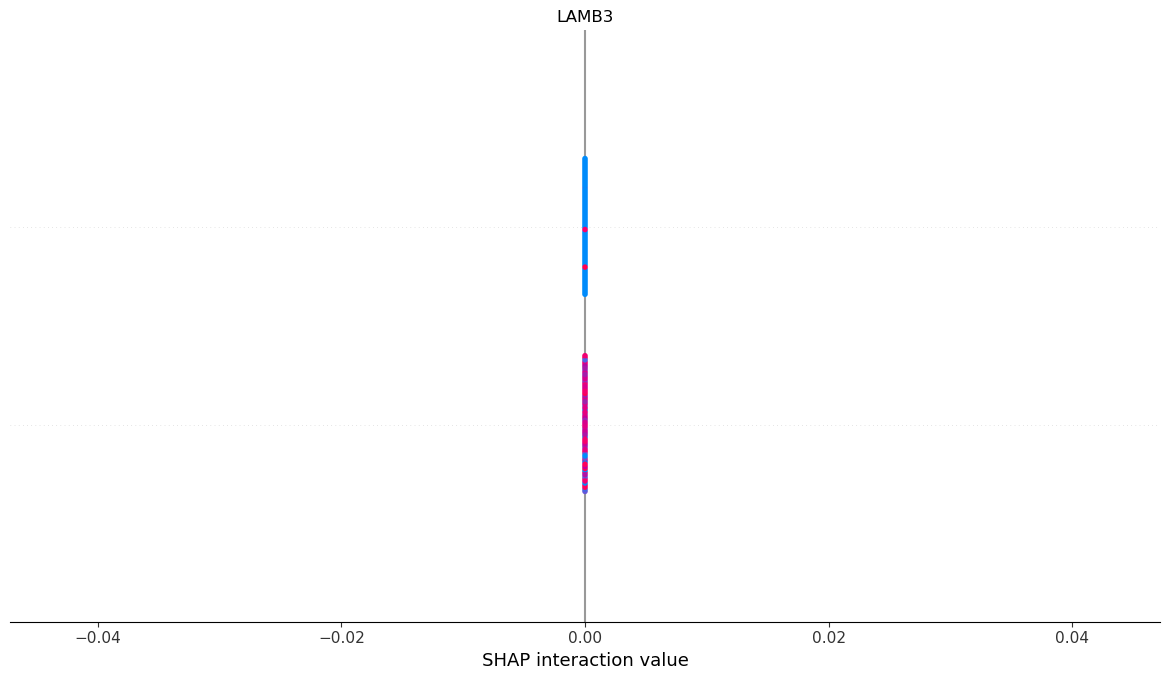

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score, recall_score, precision_score
)
from matplotlib_venn import venn3
import shap

# 1. 60-20-20 split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# 2. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. RFE with Multiple Base Models and Hyperparameter Tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_configs = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "class_weight": ['balanced']
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, solver='liblinear'),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ['l1', 'l2'],
            "class_weight": ['balanced']
        }
    },
    "SVM (Linear)": {
        "model": SVC(kernel='linear', probability=True),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "class_weight": ['balanced']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                               scale_pos_weight=(sum(y_train==0)/sum(y_train==1)), error_score='raise'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7]
        }
    }
}

evaluation_summary = []
rfe_scores = {}
selected_features_per_model = {}
best_models = {}

for name, config in model_configs.items():
    print(f"\n>>> Processing {name}")
    base_model = config["model"]
    param_grid = config["params"]

    rfe = RFE(estimator=base_model, n_features_to_select=727, step=0.1)
    rfe.fit(X_train_scaled, y_train)
    selected_features = X.columns[rfe.support_].tolist()
    selected_features_per_model[name] = selected_features

    X_train_rfe = rfe.transform(X_train_scaled)
    X_val_rfe = rfe.transform(X_val_scaled)
    X_test_rfe = rfe.transform(X_test_scaled)

    grid = GridSearchCV(base_model, param_grid, cv=kfold, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_rfe, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_train_pred = best_model.predict(X_train_rfe)
    y_val_pred = best_model.predict(X_val_rfe)
    y_test_pred = best_model.predict(X_test_rfe)

    y_train_prob = best_model.predict_proba(X_train_rfe)[:, 1]
    y_val_prob = best_model.predict_proba(X_val_rfe)[:, 1]
    y_test_prob = best_model.predict_proba(X_test_rfe)[:, 1]

    cv_scores = cross_val_score(best_model, X_train_rfe, y_train, cv=kfold, scoring='f1_macro')
    rfe_scores[name] = cv_scores

    evaluation_summary.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Validation Accuracy": accuracy_score(y_val, y_val_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train F1": f1_score(y_train, y_train_pred, average='macro'),
        "Validation F1": f1_score(y_val, y_val_pred, average='macro'),
        "Test F1": f1_score(y_test, y_test_pred, average='macro'),
        "Train Precision": precision_score(y_train, y_train_pred, average='macro'),
        "Validation Precision": precision_score(y_val, y_val_pred, average='macro'),
        "Test Precision": precision_score(y_test, y_test_pred, average='macro'),
        "Train Recall": recall_score(y_train, y_train_pred, average='macro'),
        "Validation Recall": recall_score(y_val, y_val_pred, average='macro'),
        "Test Recall": recall_score(y_test, y_test_pred, average='macro'),
        "Train AUC": roc_auc_score(y_train, y_train_prob),
        "Validation AUC": roc_auc_score(y_val, y_val_prob),
        "Test AUC": roc_auc_score(y_test, y_test_prob),
        "CV F1 Mean": cv_scores.mean(),
        "CV F1 Std": cv_scores.std()
    })

    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train_rfe, y_train, cv=kfold, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="CV")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Macro")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary
summary_df = pd.DataFrame(evaluation_summary)
summary_df.to_csv("model_evaluation_summary.csv", index=False)

# Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(summary_df.set_index("Model").drop(columns=["CV F1 Mean", "CV F1 Std"]), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Model Evaluation Metrics")
plt.tight_layout()
plt.show()

# CV Score Boxplot
cv_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in rfe_scores.items()]))
cv_df.plot(kind='box', figsize=(10, 5), title='Cross-Validation F1 Score Distribution')
plt.ylabel("F1 Macro")
plt.grid(True)
plt.tight_layout()
plt.show()

# SHAP for best model
best_model_name = summary_df.sort_values("Validation F1", ascending=False).iloc[0]["Model"]
final_model = best_models[best_model_name]
final_features = selected_features_per_model[best_model_name]

X_train_final = X_train[final_features].values
X_test_final = X_test[final_features].values

explainer = shap.Explainer(final_model, X_train_final)
shap_values = explainer(X_test_final)
shap.summary_plot(shap_values, features=X_test_final, feature_names=final_features)


In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Logistic LASSO with hyperparameter tuning
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42,class_weight="balanced")
param_grid = {'C': np.logspace(-4, 4, 20)}  # Tune C (inverse of lambda)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
print(f"Best C: {best_C:.6f}")

# Step 5: Select genes (non-zero coefficients)
coef = best_model.coef_[0]
selected_genes = X_train.columns[coef != 0].tolist()
selected_coefs = coef[coef != 0]
print(f"Number of selected genes: {len(selected_genes)}")
print(f"Selected genes: {selected_genes}")

# Step 6: Save selected genes and their coefficients to CSV
genes_importance = pd.DataFrame({
    'Gene': selected_genes,
    'Coefficient': selected_coefs,
    'Abs_Coefficient': np.abs(selected_coefs)  # For ranking by importance
})
genes_importance = genes_importance.sort_values(by='Abs_Coefficient', ascending=False)
genes_importance.to_csv('All_Results/selected_genes_lasso_All.csv', index=False)
print("Selected genes saved to 'selected_genes_lasso.csv'")

# Step 7: Build model on selected genes
if len(selected_genes) > 0:
    # Subset data to selected genes
    X_train_selected = X_train[selected_genes]
    X_test_selected = X_test[selected_genes]

    # Train logistic regression (no L1 penalty) on selected genes
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42,class_weight="balanced")
    model.fit(X_train_selected, y_train)

    # Step 8: Evaluate model
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
else:
    print("No genes selected. Cannot build model.")

Best C: 3792.690191
Number of selected genes: 902
Selected genes: ['SLC25A43', 'MIR3615', 'TUBB4B', 'RPL7', 'ACSF3', 'CLCA2', 'LEMD1', 'IRX2', 'SLC44A5', 'DHDH', 'MIR4775', 'SLC25A4', 'VASN', 'RPS15', 'ID1', 'SNORD45A', 'MIR4482', 'SCARNA16', 'ENO1', 'POLE2', 'CXCL10', 'AZIN1', 'VDAC1', 'MIR4653', 'RHOC', 'MIR4730', 'STK38', 'CTNNA1', 'RPL27', 'LINC02585', 'NRGN', 'C12orf54', 'KRT86', 'TRAV30', 'CLTB', 'BHLHE40', 'RPS21', 'FBLIM1', 'SNORD99', 'MUC5B.AS1', 'SOCS3', 'LINC00511', 'NOP10', 'ALKBH7', 'PLAAT2', 'MIR3677', 'CCT4', 'CYP2B7P', 'MYO7A', 'ATP6V1G1', 'SNORD14A', 'A2ML1', 'ANXA2R', 'VAMP8', 'BCYRN1', 'THYN1', 'MIR6755', 'HSPB1', 'SNORD58C', 'RHCG', 'ZNF544', 'MIR197', 'CXCL11', 'MIR4647', 'SNORA56', 'RN7SL1', 'HSPB2.C11orf52', 'PLPP2', 'NPW', 'AIMP1', 'MIR5193', 'HNRNPH1', 'RFNG', 'IGKV1D.42', 'CCL3L3', 'IGKJ1', 'TOP2A', 'CRIP2', 'MIR6851', 'RPL15', 'LAG3', 'MT1M', 'MT.ND3', 'ATP6V1F', 'TFF3', 'YPEL5', 'EFNB2', 'MT.ND2', 'NDUFA8', 'MT.ND1', 'DDX5', 'CEBPB', 'CD63', 'RNU7.1', 'TRIP6

In [32]:
from sklearn.model_selection import cross_val_score
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
param_grid = {'C': np.logspace(-4, 4, 50)}  # Tune C (inverse of regularization strength lambda)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
best_cv_score = grid_search.best_score_
print(f"Best C: {best_C:.6f}")
print(f"Cross-validation AUC-ROC for LASSO: {best_cv_score:.3f}")

# Step 5: Extract all genes with non-zero coefficients
coef = best_model.coef_[0]
selected_genes = X_train.columns[coef != 0].tolist()
selected_coefs = coef[coef != 0]
print(f"Number of selected genes with non-zero coefficients: {len(selected_genes)}")
print(f"Selected genes: {selected_genes}")

# Step 6: Save selected genes and their coefficients to CSV, ranked by importance
genes_importance = pd.DataFrame({
    'Gene': selected_genes,
    'Coefficient': selected_coefs,
    'Abs_Coefficient': np.abs(selected_coefs)
})
genes_importance = genes_importance.sort_values(by='Abs_Coefficient', ascending=False)
genes_importance.to_csv('All_Results/selected_genes_all_nonzero_LASSO_ALL.csv', index=False)
print("Selected genes with non-zero coefficients saved to 'selected_genes.csv'")

# Step 7: Build and evaluate model on selected genes
if len(selected_genes) > 0:
    # Subset data to selected genes
    X_train_selected = X_train[selected_genes]
    X_test_selected = X_test[selected_genes]

    # Train logistic regression (no regularization) on selected genes
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
    
    # Evaluate model using 5-fold cross-validation on training data
    cv_accuracy = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy').mean()
    cv_auc = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='roc_auc').mean()
    cv_precision = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='precision').mean()
    cv_recall = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='recall').mean()
    cv_f1 = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1').mean()

    print("\nCross-Validation Performance (5-fold) on Selected Genes:")
    print(f"Accuracy: {cv_accuracy:.3f}")
    print(f"AUC-ROC: {cv_auc:.3f}")
    print(f"Precision: {cv_precision:.3f}")
    print(f"Recall: {cv_recall:.3f}")
    print(f"F1-Score: {cv_f1:.3f}")

    # Fit model on full training data and evaluate on test set
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

    # Test set metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    print("\nTest Set Performance:")
    print(f"Accuracy: {test_accuracy:.3f}")
    print(f"AUC-ROC: {test_auc:.3f}")
    print(f"Precision: {test_precision:.3f}")
    print(f"Recall: {test_recall:.3f}")
    print(f"F1-Score: {test_f1:.3f}")
else:
    print("No genes with non-zero coefficients selected. Cannot build model.")

Best C: 0.126486
Cross-validation AUC-ROC for LASSO: 0.998
Number of selected genes with non-zero coefficients: 42
Selected genes: ['KRT17', 'MMP1', 'MUC5B.AS1', 'MT.ND3', 'MT.ND2', 'MT.ND1', 'SNORD29', 'MT.ATP8', 'IGHV1.18', 'TMSB4X', 'TMSB10', 'MT.CO1', 'GAPDH', 'MT.CYB', 'PSAP', 'FTL', 'IGKC', 'TREM2', 'MT.ND4', 'MT.ATP6', 'S100A6', 'MT.ND4L', 'SNORD58B', 'MT.RNR1', 'SNORA48', 'MT.RNR2', 'SNORD36A', 'MT.ND5', 'MT.ND6', 'MT.CO3', 'AIM2', 'ACTG1', 'RPS12', 'ACTB', 'SNORA73A', 'MT.CO2', 'MIR4426', 'RPL3', 'RPS18', 'MT.TV', 'S100A11', 'IGLC1']
Selected genes with non-zero coefficients saved to 'selected_genes.csv'

Cross-Validation Performance (5-fold) on Selected Genes:
Accuracy: 1.000
AUC-ROC: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

Test Set Performance:
Accuracy: 1.000
AUC-ROC: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import warnings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Train Random Forest with hyperparameter tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Step 2: Extract top important genes
importances = best_rf.feature_importances_
selected_rf_genes_df = pd.DataFrame({
    'Gene': X_train.columns,
    'Importance': importances
})
selected_rf_genes_df = selected_rf_genes_df[selected_rf_genes_df['Importance'] > 0]
selected_rf_genes_df['Rank'] = selected_rf_genes_df['Importance'].rank(ascending=False)
selected_rf_genes_df = selected_rf_genes_df.sort_values(by='Importance', ascending=False)

# Save all important genes to CSV
selected_rf_genes_df.to_csv('All_Results/selected_genes_random_forest_All.csv', index=False)
print(f"Number of selected important genes: {selected_rf_genes_df.shape[0]}")
print("Top important genes saved to 'selected_genes_random_forest.csv'")

# Step 3: Build model using selected genes only
selected_rf_genes = selected_rf_genes_df['Gene'].tolist()
X_train_rf_selected = X_train[selected_rf_genes]
X_test_rf_selected = X_test[selected_rf_genes]

model_rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Cross-validation on training set
cv_accuracy_rf = cross_val_score(model_rf_selected, X_train_rf_selected, y_train, cv=5, scoring='accuracy').mean()
cv_auc_rf = cross_val_score(model_rf_selected, X_train_rf_selected, y_train, cv=5, scoring='roc_auc').mean()
cv_precision_rf = cross_val_score(model_rf_selected, X_train_rf_selected, y_train, cv=5, scoring='precision').mean()
cv_recall_rf = cross_val_score(model_rf_selected, X_train_rf_selected, y_train, cv=5, scoring='recall').mean()
cv_f1_rf = cross_val_score(model_rf_selected, X_train_rf_selected, y_train, cv=5, scoring='f1').mean()

print("\nCross-Validation Performance (5-fold) on Selected Genes (Random Forest):")
print(f"Accuracy: {cv_accuracy_rf:.3f}")
print(f"AUC-ROC: {cv_auc_rf:.3f}")
print(f"Precision: {cv_precision_rf:.3f}")
print(f"Recall: {cv_recall_rf:.3f}")
print(f"F1-Score: {cv_f1_rf:.3f}")

# Train on full training data and evaluate on test set
model_rf_selected.fit(X_train_rf_selected, y_train)
y_pred_rf = model_rf_selected.predict(X_test_rf_selected)
y_pred_proba_rf = model_rf_selected.predict_proba(X_test_rf_selected)[:, 1]

# Test set performance
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
test_precision_rf = precision_score(y_test, y_pred_rf)
test_recall_rf = recall_score(y_test, y_pred_rf)
test_f1_rf = f1_score(y_test, y_pred_rf)

print("\nTest Set Performance (Random Forest):")
print(f"Accuracy: {test_accuracy_rf:.3f}")
print(f"AUC-ROC: {test_auc_rf:.3f}")
print(f"Precision: {test_precision_rf:.3f}")
print(f"Recall: {test_recall_rf:.3f}")
print(f"F1-Score: {test_f1_rf:.3f}")


Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Number of selected important genes: 164
Top important genes saved to 'selected_genes_random_forest.csv'

Cross-Validation Performance (5-fold) on Selected Genes (Random Forest):
Accuracy: 0.996
AUC-ROC: 1.000
Precision: 0.995
Recall: 1.000
F1-Score: 0.998

Test Set Performance (Random Forest):
Accuracy: 1.000
AUC-ROC: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
